# 14.1g: Single Token Velocity Trajectories

**Quantization structure at the single-particle level**

## The Question

What does the velocity trajectory look like for individual tokens?

Expected features:
- **Dead tokens**: Exponential decay → quantized stepping (discrete velocity bands) → frozen at zero
- **Live tokens**: Same decay, then **cosmic ray spike** when predicted → escape or continued evolution

## Visualization Strategy

**Scatter plot** (not line plot) to show individual update events. This reveals:
- Quantization bands (horizontal stripes at discrete velocity levels)
- Gaps where no updates occur (forbidden by quantization)
- Sudden jumps (cosmic ray hits)

**Linear scales** (x and y) to see absolute structure clearly.

## Parameters

In [32]:
# Data
DATA_PATH = "../data/instrumented_run/gradient_delta_history.safetensors"

# Tokens to plot (add more to see multiple overlaid)
TOKENS_TO_PLOT = [
    ord('&'),  # ASCII 38 (dead token)
    ord('t'),  # ASCII 116 (live token)
    # ord('Q'),
]

# Visualization
DPI = 100
SCATTER_SIZE = 10
SCATTER_ALPHA = 0.6
COLORMAP = 'tab10'  # Distinct colors for each token

RANDOM_SEED = 42

## Imports

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [34]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

recorded_steps = data['recorded_steps'].numpy()
dead_token_ids = data['dead_token_ids'].tolist()
live_token_ids = data['live_token_ids'].tolist()

deltas = data['deltas']  # [n_recorded, vocab_size, hidden_dim]

n_recorded = len(recorded_steps)

print(f"\n  Recorded steps: {n_recorded}")
print(f"  Step range: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"  All tokens tracked: {deltas.shape[1]}")
print(f"  Dead tokens: {len(dead_token_ids)}")
print(f"  Live tokens: {len(live_token_ids)}")
print(f"\n✓ Data loaded")

Loading: ../data/instrumented_run/gradient_delta_history.safetensors

  Recorded steps: 10000
  Step range: 0 to 10000
  All tokens tracked: 128
  Dead tokens: 51
  Live tokens: 77

✓ Data loaded


## Compute Velocities

In [35]:
print("Computing velocities...")

# L2 norms of deltas = velocity
velocities_all = torch.norm(deltas, p=2, dim=2).numpy()  # [n_recorded, vocab_size]

print(f"✓ Velocities computed: {velocities_all.shape}")

Computing velocities...
✓ Velocities computed: (10000, 128)


## Extract Trajectories for Requested Tokens

In [36]:
print("Extracting trajectories...")

trajectories = {}  # {token_id: (steps, velocities, is_dead)}

for token_id in TOKENS_TO_PLOT:
    if token_id < velocities_all.shape[1]:
        # Extract velocity trajectory for this token
        trajectory = velocities_all[:, token_id]
        is_dead = token_id in dead_token_ids
        trajectories[token_id] = (recorded_steps, trajectory, is_dead)
        
        token_type = "DEAD" if is_dead else "LIVE"
        print(f"  Token {token_id} ('{chr(token_id)}'): {token_type}")
    else:
        print(f"  WARNING: Token {token_id} ('{chr(token_id)}') is out of range (vocab_size={velocities_all.shape[1]})!")

print(f"\n✓ Extracted {len(trajectories)} trajectories")

Extracting trajectories...
  Token 38 ('&'): DEAD
  Token 116 ('t'): LIVE

✓ Extracted 2 trajectories


## Plot: Velocity vs Time (Scatter)

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_56490/1820812612.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(COLORMAP)(np.linspace(0, 1, len(trajectories)))


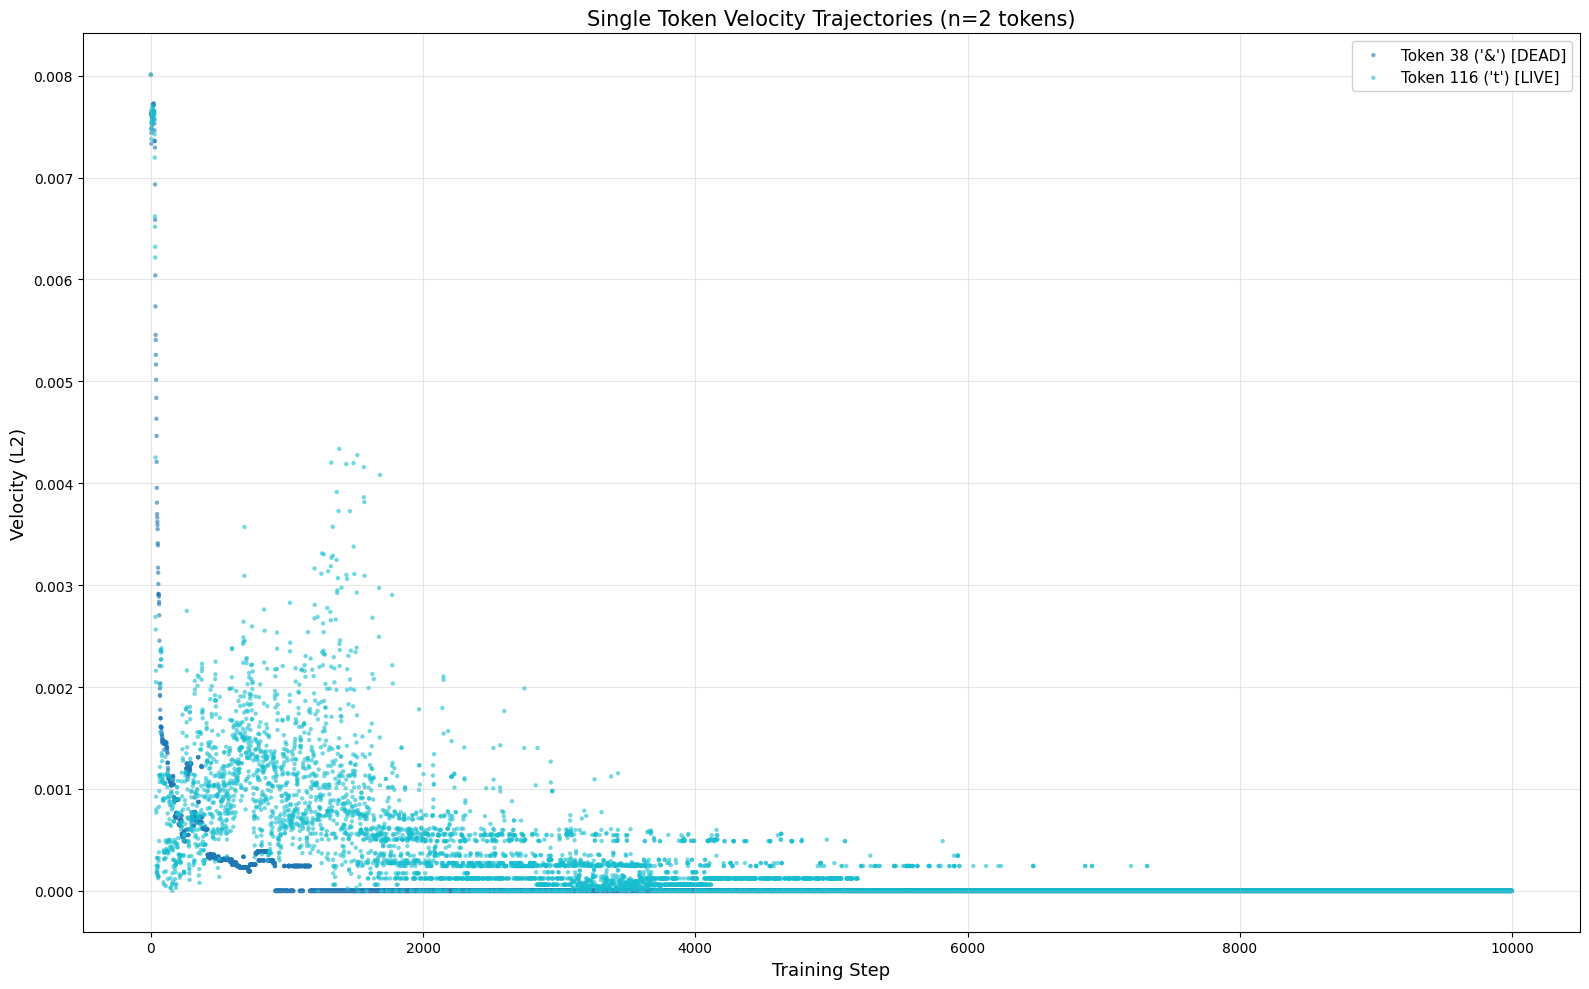


✓ Scatter plot complete


In [39]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=DPI)

# Color palette
colors = plt.cm.get_cmap(COLORMAP)(np.linspace(0, 1, len(trajectories)))

for i, (token_id, (steps, velocities, is_dead)) in enumerate(trajectories.items()):
    token_type = "DEAD" if is_dead else "LIVE"
    label = f"Token {token_id} ('{chr(token_id)}') [{token_type}]"
    
    ax.scatter(steps, velocities, s=SCATTER_SIZE, alpha=SCATTER_ALPHA, 
               color=colors[i], label=label, edgecolors='none')

ax.set_xlabel('Training Step', fontsize=13)
ax.set_ylabel('Velocity (L2)', fontsize=13)
ax.set_title(f'Single Token Velocity Trajectories (n={len(trajectories)} tokens)', fontsize=15)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_xscale('linear')
ax.set_yscale('linear')

plt.tight_layout()
plt.show()

print(f"\n✓ Scatter plot complete")

## Statistics

In [40]:
print(f"\n{'='*80}")
print(f"SINGLE TOKEN TRAJECTORY STATISTICS")
print(f"{'='*80}\n")

for token_id, (steps, velocities, is_dead) in trajectories.items():
    token_type = "DEAD" if is_dead else "LIVE"
    print(f"Token {token_id} ('{chr(token_id)}') [{token_type}]:")
    print(f"  Initial velocity: {velocities[0]:.6e}")
    print(f"  Final velocity: {velocities[-1]:.6e}")
    print(f"  Max velocity: {velocities.max():.6e}")
    print(f"  Mean velocity: {velocities.mean():.6e}")
    print(f"  Cooling ratio (final/initial): {velocities[-1] / velocities[0]:.6f}")
    
    # Count steps at exactly zero
    zero_steps = np.sum(velocities == 0)
    print(f"  Steps at zero: {zero_steps} / {len(velocities)} ({100 * zero_steps / len(velocities):.1f}%)")
    
    # Count unique velocity values (reveals quantization)
    unique_velocities = np.unique(velocities)
    print(f"  Unique velocity values: {len(unique_velocities)}")
    
    print()

print(f"{'='*80}")


SINGLE TOKEN TRAJECTORY STATISTICS

Token 38 ('&') [DEAD]:
  Initial velocity: 8.006845e-03
  Final velocity: 0.000000e+00
  Max velocity: 8.006845e-03
  Mean velocity: 8.806700e-05
  Cooling ratio (final/initial): 0.000000
  Steps at zero: 8958 / 10000 (89.6%)
  Unique velocity values: 330

Token 116 ('t') [LIVE]:
  Initial velocity: 8.014983e-03
  Final velocity: 0.000000e+00
  Max velocity: 8.014983e-03
  Mean velocity: 2.731114e-04
  Cooling ratio (final/initial): 0.000000
  Steps at zero: 5730 / 10000 (57.3%)
  Unique velocity values: 1375



## Interpretation

**What to look for in the scatter plot:**

1. **Quantization bands**: Horizontal stripes at discrete velocity levels
   - Dead tokens confined to these bands (bfloat16 lattice)
   - Gaps between bands (velocities forbidden by quantization)

2. **Decay structure**: Points cluster at progressively lower velocities over time
   - Early: dense cloud at high velocity
   - Late: sparse points near zero

3. **Cosmic ray events** (live tokens only): Sudden jumps to high velocity
   - One outlier point way above the decay envelope
   - Marks the step when token was predicted correctly

4. **Freeze point**: Long stretch of points at exactly zero
   - Updates too small to overcome quantization
   - Token effectively frozen

**Dead vs live:**
- Dead tokens show clean exponential decay + quantization structure
- Live tokens show same pattern + occasional cosmic ray spike